# Linear regression

## Task 1

Load data from the Forest Fires dataset (forestfires.csv) about forest fires in Portugal. The task is to use linear regression to learn how to predict the area coordinate (fire area) as a linear combination of other data.

For simplicity, you can replace the month coordinate with the summer season indicator, and do not use the day coordinate at all. If desired, you can make the conversion in a different way. Also add a coordinate that is identically equal to one (the weight at this coordinate is interpreted as a shift).

Divide the sample into two parts in a ratio of 7: 3. In the first part, build a regression model. Apply the model to the second part of the sample and calculate the standard error based on it.

For the area variable, perform the conversion $f(x) = \ln(x+c)$ and build a new regression model for it. Calculate the root-mean-square error for the converted values. At what $c$ do predictions work best?

With $c$ selected, split the sample in a 7:3 ratio in different ways (shuffling each time). Find a way to assess the variability in the quality of the partitioning. Does the quality change much? Conclude.

## Solution

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps
import pandas as pd
import random

pd.options.mode.chained_assignment = None

Get data from the table

In [2]:
forestfires_data = pd.read_csv('forestfires.csv')

Let's make transformations on the data. Replace the names of months with their numbers, exclude data about days, and add a column with a shift equal to one.

In [3]:
forestfires_data.loc[:, 'month'][(forestfires_data.month == 'jan')] = 1
forestfires_data.loc[:, 'month'][(forestfires_data.month == 'feb')] = 2
forestfires_data.loc[:, 'month'][(forestfires_data.month == 'mar')] = 3
forestfires_data.loc[:, 'month'][(forestfires_data.month == 'apr')] = 4
forestfires_data.loc[:, 'month'][(forestfires_data.month == 'may')] = 5
forestfires_data.loc[:, 'month'][(forestfires_data.month == 'jun')] = 6

forestfires_data.loc[:, 'month'][(forestfires_data.month == 'jul')] = 7
forestfires_data.loc[:, 'month'][(forestfires_data.month == 'aug')] = 8
forestfires_data.loc[:, 'month'][(forestfires_data.month == 'sep')] = 9
forestfires_data.loc[:, 'month'][(forestfires_data.month == 'oct')] = 10
forestfires_data.loc[:, 'month'][(forestfires_data.month == 'nov')] = 11
forestfires_data.loc[:, 'month'][(forestfires_data.month == 'dec')] = 12

forestfires_data.drop(['day'], axis=1, inplace=True)
forestfires_data['shift'] = 1

Output the first $5 $ rows from the table.

In [4]:
forestfires_data.head()

X  Y month  FFMC   DMC     DC  ISI  temp  RH  wind  rain  area  shift
0  7  5     3  86.2  26.2   94.3  5.1   8.2  51   6.7   0.0   0.0      1
1  7  4    10  90.6  35.4  669.1  6.7  18.0  33   0.9   0.0   0.0      1
2  7  4    10  90.6  43.7  686.9  6.7  14.6  33   1.3   0.0   0.0      1
3  8  6     3  91.7  33.3   77.5  9.0   8.3  97   4.0   0.2   0.0      1
4  8  6     3  89.3  51.3  102.2  9.6  11.4  99   1.8   0.0   0.0      1

Let's learn how to mix our data using random.shuffle

In [5]:
#translate the table into a matrix
matrix = forestfires_data.values
random.shuffle(matrix)
#translate the matrix into a table
shuffled_forestfires = pd.DataFrame(data=matrix, columns=forestfires_data.columns)
shuffled_forestfires.head()

X  Y month  FFMC   DMC     DC  ISI  temp  RH wind rain area shift
0  7  5     3  86.2  26.2   94.3  5.1   8.2  51  6.7    0    0     1
1  7  5     3  86.2  26.2   94.3  5.1   8.2  51  6.7    0    0     1
2  7  4    10  90.6  43.7  686.9  6.7  14.6  33  1.3    0    0     1
3  8  6     3  91.7  33.3   77.5    9   8.3  97    4  0.2    0     1
4  7  4    10  90.6  35.4  669.1  6.7    18  33  0.9    0    0     1

There is an easier way. We will use it.

In [6]:
shuffled = forestfires_data.sample(frac=1)
shuffled.head()

X  Y month  FFMC    DMC     DC   ISI  temp  RH  wind  rain  area  shift
424  8  6     8  93.7  231.1  715.1   8.4  26.9  31   3.6   0.0  4.96      1
70   4  5     3  91.2   48.3   97.8  12.5  15.8  27   7.6   0.0  0.00      1
394  6  5     2  84.1    4.6   46.7   2.2   5.3  68   1.8   0.0  0.00      1
290  2  5     7  91.6  104.2  474.9   9.0  18.7  53   1.8   0.0  0.00      1
247  2  4     8  92.2   91.6  503.6   9.6  20.7  70   2.2   0.0  0.75      1

Let's create a function that divides the sample into training and test parts, and selects the area parameter column from them

In [7]:
def data_cut(data):
    limit = int(len(data)*0.7)

    #divide the sample into train and test parts
    train_data = data[:limit]
    test_data = data[limit:]

    #save data on the area of fires
    train_area = train_data.area 
    test_area = test_data.area

    #and exclude them from the tables
    train_data.drop(['area'], axis=1, inplace=True)
    test_data.drop(['area'], axis=1, inplace=True)
    return train_data, train_area, test_data, test_area

Below, a regression model is built for the first part of the sample. The resulting model is applied to the second part of the sample, and the standard deviation is calculated.

In [8]:
train_data, train_area, test_data, test_area = data_cut(shuffled)

#bring the data to the numpy.array type and build the model
Z = train_data.values.astype(float)
X = train_area.values.astype(float)
    
#the estimator calculation, a least-squares
estimator = np.linalg.inv(Z.T @ Z) @ Z.T @ X

print('MSE: ', 
    round(np.sum((test_area.values.astype(float
    ) - test_data.values.astype(float) @ estimator)**2) / len(test_area), 5))

MSE:  8199.72333


We will do the same, but now we will build a regression model using the converted values of the area parameter for different $c$. Note that since we are not actually evaluating the parameter itself here, but the logarithm of its offset value, we need to make the corresponding reverse transition to calculate the error of the area parameter estimation.

In [9]:
C = np.linspace(1, 10, 10000)
MSE = np.zeros(len(C))

for i, c in enumerate(C):
    X_log = np.log(X + c) #converting area data
    
    estimator = np.linalg.inv(Z.T @ Z) @ Z.T @ X_log
    
    #counting errors with reverse transition
    MSE[i] = np.sum((test_area.values.astype(float
    ) - np.exp(test_data.values.astype(float) @ estimator) - c)**2) / len(test_area)

Let's plot the dependence of the root-mean-square error on the value of $c$.

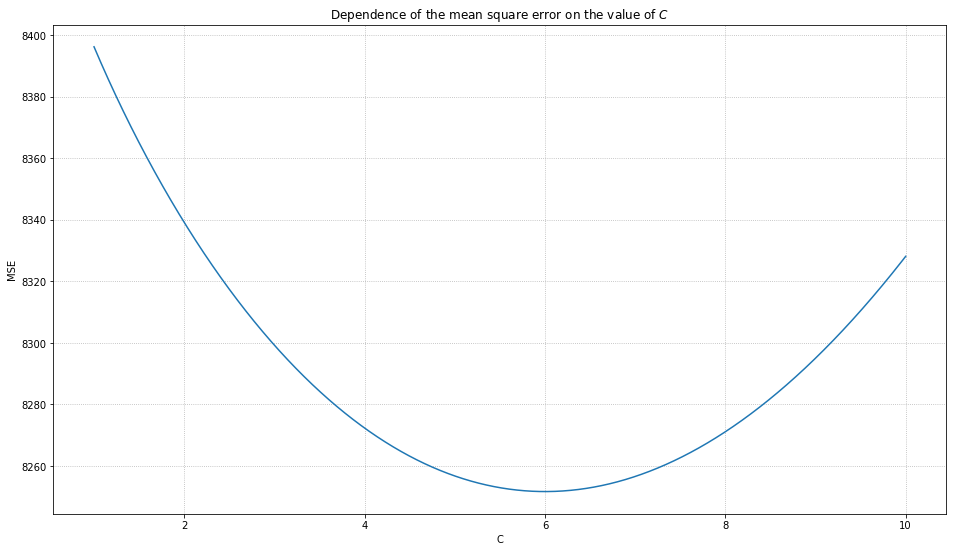

In [10]:
plt.figure(figsize=(16, 9))
plt.plot(C, MSE)

plt.xlabel('C', fontsize=10)
plt.ylabel('MSE', fontsize=10)
plt.title('Dependence of the mean square error on the value of $C$')

plt.grid(ls=':')
plt.show()

You can see that, depending on the launch, the value of $c$, at which the minimum RMS error is reached, fluctuates in the range $[2, 10]$. For certainty, let's take the value $c$ equal to $6$.

In [11]:
n = 1000
MSE = np.zeros(n)

for i in range(n):
    shuffled = forestfires_data.sample(frac=1)
    
    train_data, train_area, test_data, test_area = data_cut(shuffled)
    
    Z = train_data.values.astype(float)
    X = train_area.values.astype(float)
    X_log = np.log(X + 6)
    
    estimator = np.linalg.inv(Z.T @ Z) @ Z.T @ X_log
    
    #ounting errors with reverse transition
    MSE[i] = np.sum((test_area.values.astype(float
    ) - np.exp(test_data.values.astype(float) @ estimator) - 6)**2) / len(test_area)

So, we got an array of MSE values for variously mixed samples. Let's display these values on the graph for each sample and get a thousand points.

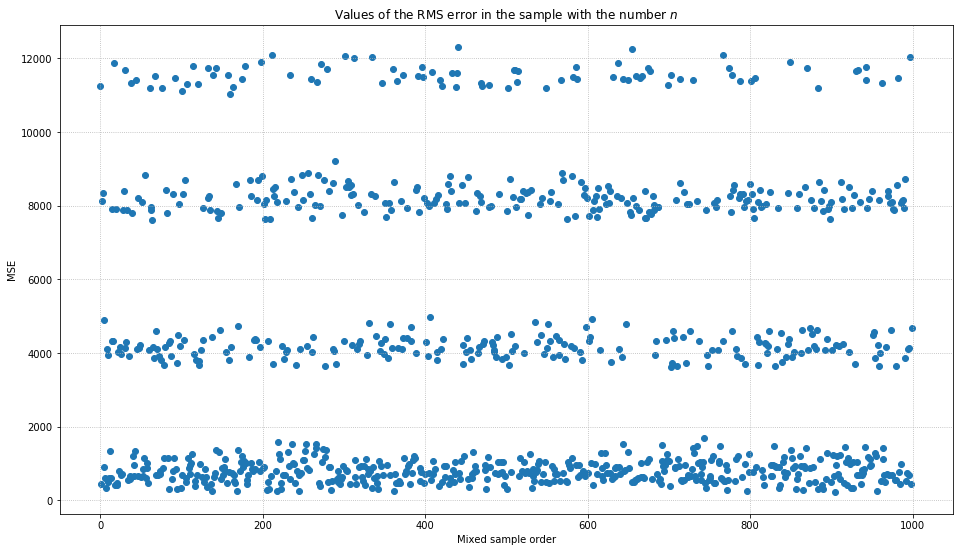

In [12]:
plt.figure(figsize=(16, 9))
plt.scatter(np.arange(n), MSE)

plt.xlabel('Mixed sample order', fontsize=10)
plt.ylabel('MSE', fontsize=10)
plt.title('Values of the RMS error in the sample with the number $n$')

plt.grid(ls=':')
plt.show()

Let's calculate the sample variance and the average for estimating the quality spread from the split, using the obtained values of standard errors.

In [13]:
print('Sample variance: ', round(np.var(MSE), 5))
print('Average: ', round(MSE.mean(), 5))

Sample variance:  13972766.10927
Average:  4092.78253


## Conclusion

In the course of the experiments, an attempt was made to predict the area parameter using linear regression in the form of a linear combination of other variables.

The mean square error calculated initially, due to its large size in comparison with the data for the area of fires from the table, reveals the absence of an explicit linear dependence of the area parameter on the other values.

Next, an attempt was made to build a model based on the prolog values of the area parameter with a shift. This intention can be explained by the fact that in the case of exponential dependence of the fire area on other factors (which is quite acceptable from the point of view of reality), we will have a model that is more suitable for finding an estimate using the linear method.

Thus, considering different values of the parameter $c$ and found a noticeable variation of this parameter depending on the mixing of the sample, in general, the RMS errors in the at least first graph in the second case are lower than in the first attempt.

For a fixed value of $c$, error values were calculated for estimators obtained from models for variously mixed samples. The last graph shows the spread of error values according to the sample number. The graph shows a clear four bands and a significant change in the quality of the parameter estimators. For small values, this may be due to the fact that the constant $c$ becomes relatively large, which means that we are increasingly evaluating not so much the parameter as the constant, as a result of which, of course, the error is reduced, but this should not please us. Taking into account the impact of outliers (very large error values), we conclude that in this situation, it is convenient to use the average to error estimator. Indeed, in comparison with a very large value, for example, the sample variance, the average looks much more adequate.

In general, we can conclude that the linear model is not quite successful for predicting the fire area parameter in our case.

## Task 2

$$X_i = \beta_1+i\beta_2+\varepsilon_0+\ldots+\varepsilon_i,\, i= 0, 1, \ldots, n$$ $-$ the distance that the tram traveled in $i$ seconds according to the sensor reading. Here $ \beta_1$ $ - $ initial distance, $ \beta_2$ $-$ tram speed, $\varepsilon_0$ $ - $ error of the initial sensor reading. The tram travels at a constant speed, and every second the sensor records the distance the tram has traveled. The time is counted from the previous measurement, and the countdown occurs with an error. For $i = 1, \ldots, n$ the value $\varepsilon_i$ is a distance increment error, that is, $\varepsilon_i = \varepsilon_i^t \beta_2,$ where $\varepsilon_i^t$ is a time reference error. All errors $\varepsilon_i$ are independent and distributed according to the law $N(0, \sigma^2)$.

Reduce the problem to a linear model and find the least squares estimators for the initial distance $ \beta_1$ and the speed $ \beta_2,$ as well as an unbiased estimate for $\sigma^2,$ from which you Express the estimate of the time reference variance.

Take the data from the regression.csv. Conclude.

## Solution

Get the distance values from the table

In [14]:
file = open("regression.csv", "r")
X = np.array(file.readlines()).astype("float64")
file.close()

Let's reduce the problem to a linear model. To do this, enter the $Z$ and $Y$matrices accordingly.

In [15]:
n = len(X)

Z = np.zeros((n, 2))
Z[0][0] = 1
Z[1:, 1] = 1

Y = X
Y[1:] = Y[1:] - X[:-1]

Find the least-squares estimators for the parameters $ \beta_1$ and $ \beta_2$, and get an unbiased estimator of $ \sigma^2$ and get an estimator of the time reference variance using the ratio $Var{\varepsilon} = Var{\varepsilon^t\beta_2} = \beta_2^2Var{\varepsilon^t}$.

In [16]:
estimators = np.linalg.inv(Z.T @ Z) @ Z.T @ Y
squared_sigma = np.linalg.norm(Y - Z @ estimators)**2 / (n - 2)
squared_sigma_t = squared_sigma / estimators[1] ** 2

print('Estimators:')
print('beta_1 =', round(estimators[0], 4))
print('beta_2 =', round(estimators[1], 4))
print('squared_sigma =', round(squared_sigma, 4))
print('squared_sigma_t =', round(squared_sigma_t, 4))

Estimators:
beta_1 = 82.0053
beta_2 = 11.9708
squared_sigma = 1.5252
squared_sigma_t = 0.0106


## Conclusion

As a result of reducing the problem to the conditions of applicability of linear regression, a linear regression model was constructed in this problem and estimators were obtained using the least squares method for the parameters $ \beta_1$ and $ \beta_2$. We also obtained an estimator of the variance, which is unbiased due to the RMS properties, and expressed an estimator of the variance of the time measurement error. When comparing these values, it is found that as a result of a fairly small spread in the error of time measurements, per thousand observations, however, the error of the obtained estimators increases significantly.